In [3]:
import pandas as pd
df = pd.read_csv('syb66(1).csv', encoding='latin1')
df

,ï»¿T03,Population growth and indicators of fertility and mortality,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,Region/Country/Area,NaN,Year,Series,Value,Footnotes,Source
1,1,"Total, all countries or areas",2020,Population annual rate of increase (percent),0.9,NaN,"United Nations Population Division, New York, ..."
2,1,"Total, all countries or areas",2020,Total fertility rate (children per women),2.3,NaN,"United Nations Population Division, New York, ..."
3,1,"Total, all countries or areas",2020,"Infant mortality for both sexes (per 1,000 liv...",28.3,NaN,"United Nations Statistics Division, New York, ..."
4,1,"Total, all countries or areas",2020,"Maternal mortality ratio (deaths per 100,000 p...",223,NaN,"World Health Organization (WHO), the United Na..."
...,...,...,...,...,...,...,...
1523,722,SIDS,2020,"Infant mortality for both sexes (per 1,000 liv...",29,NaN,"United Nations Statistics Division, New York, ..."
1524,722,SIDS,2020,"Maternal mortality ratio (deaths per 100,000 p...",208,NaN,"World Health Organization (WHO), the United Na..."
1525,722,SIDS,2020,Life expectancy at birth for both sexes (years),72.2,NaN,"United Nations Population Division, New York, ..."
1526,722,SIDS,2020,Life expectancy at birth for males (years),69.3,NaN,"United Nations Population Division, New York, ..."


Cargando y limpiando el CSV...
Preparando datos para las dos series (2020)...
Calculando estadística...
Número de observaciones: 218
R de Pearson = -0.9148 (p = 5.262e-87)
Regresión linear: life_expectancy = -0.3645 * infant_mortality + 79.21
R-cuadrada = 0.8369
Trazando y guardando en: infant_mortality_vs_life_expectancy_2020.jpg ...


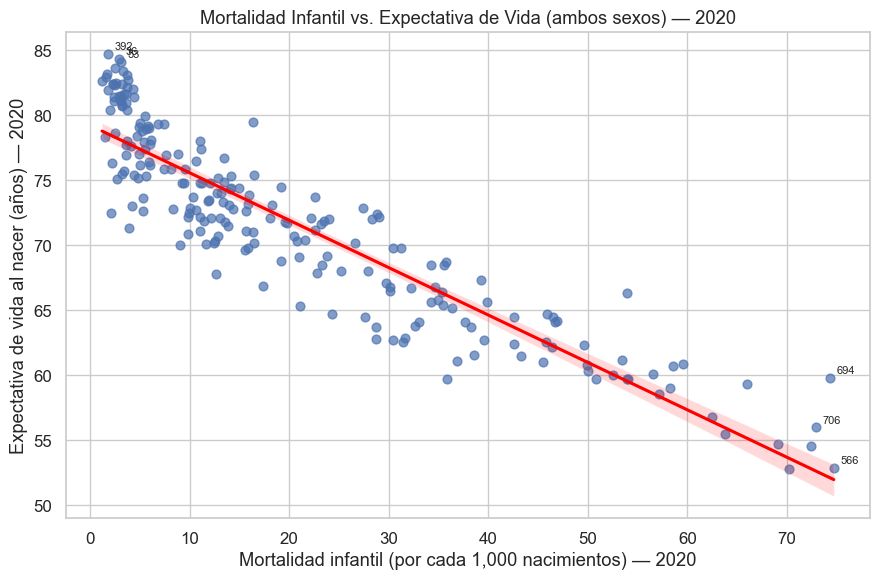

Hecho.


In [10]:
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

CSV_PATH = "SYB66(1).csv"  # adjust path if needed
OUT_JPG = "infant_mortality_vs_life_expectancy_2020.jpg"

def load_and_clean(csv_path):
    # The CSV provisto tiene una fila de metadatos, después una fila de encabezados
    # Use header=1 para ubicar el encabezado real, and quitar columnas sin nombre.
    df = pd.read_csv(csv_path, header=1, dtype=str)
    # Descartar columnas sin nombre (encabezado de columna vacía después de Region/Country/Area)
    df = df.loc[:, [c for c in df.columns if not c.startswith("Unnamed")]]
    # Estandarizar nombres de columnas
    df.columns = [c.strip() for c in df.columns]
    # Renombrar encabezados duplicados
    # Columnas esperadas: Region/Country/Area, Year, Series, Value, Footnotes, Source
    # Forzar que el valor del año se convierta a formato numérico
    df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
    df['Value'] = pd.to_numeric(df['Value'], errors='coerce')
    # Eliminar espacios en blanco de los nombres de regiones y series
    df['Region/Country/Area'] = df['Region/Country/Area'].str.strip()
    df['Series'] = df['Series'].str.strip()
    return df

def prepare_series(df):
    # Filtrado para el año 2020
    df2020 = df[df['Year'] == 2020].copy()
    # Seleccionar las dos series de interés
    im_label = "Infant mortality for both sexes (per 1,000 live births)"
    le_label = "Life expectancy at birth for both sexes (years)"
    sub = df2020[df2020['Series'].isin([im_label, le_label])]
    # Tabla pivote para que cada área tenga ambas métricas como columnas
    pivot = sub.pivot_table(
        index='Region/Country/Area',
        columns='Series',
        values='Value',
        aggfunc='first'
    )
    # Aplanar nombres de columnas
    pivot.columns = [c for c in pivot.columns]
    # Mantener solo aquellas filas donde ambos valores están presentes
    if im_label not in pivot.columns or le_label not in pivot.columns:
        raise RuntimeError("Expected series not found in the CSV. Check series names.")
    data = pivot[[im_label, le_label]].dropna()
    data = data.rename(columns={im_label: 'infant_mortality', le_label: 'life_expectancy'})
    # Reestablecer índice para que la región se vuelva una columna
    data = data.reset_index()
    return data

def plot_relationship(data, out_jpg):
    sns.set(style="whitegrid", font_scale=1.1)
    plt.figure(figsize=(9,6))
    ax = sns.regplot(x='infant_mortality', y='life_expectancy', data=data,
                     scatter_kws={'s':40, 'alpha':0.7}, line_kws={'color':'red'})
    # Anotar algunos puntos (mayor mortalidad infantil y mayor esperanza de vida)
    # seleccioné los primeros 3 por mortalidad infantil y los 3 primeros por esperanza de vida
    anno_by_im = data.nlargest(3, 'infant_mortality')
    anno_by_le = data.nlargest(3, 'life_expectancy')
    to_annotate = pd.concat([anno_by_im, anno_by_le]).drop_duplicates('Region/Country/Area')
    for _, row in to_annotate.iterrows():
        ax.annotate(row['Region/Country/Area'],
                    (row['infant_mortality'], row['life_expectancy']),
                    textcoords="offset points", xytext=(5,3), ha='left', fontsize=8)
    ax.set_xlabel("Mortalidad infantil (por cada 1,000 nacimientos) — 2020")
    ax.set_ylabel("Expectativa de vida al nacer (años) — 2020")
    ax.set_title("Mortalidad Infantil vs. Expectativa de Vida (ambos sexos) — 2020")
    plt.tight_layout()
    plt.savefig(out_jpg, dpi=150)
    plt.show()

def print_stats(data):
    x = data['infant_mortality'].to_numpy()
    y = data['life_expectancy'].to_numpy()
    # Cálculo de correlación de Perason
    r, p = stats.pearsonr(x, y)
    # Regresión linear simple (pendiente, interceptar)
    slope, intercept, r_val, p_val, std_err = stats.linregress(x, y)
    print(f"Número de observaciones: {len(data)}")
    print(f"R de Pearson = {r:.4f} (p = {p:.3e})")
    print(f"Regresión linear: life_expectancy = {slope:.4f} * infant_mortality + {intercept:.2f}")
    print(f"R-cuadrada = {r_val**2:.4f}")

def main():
    csv_file = pathlib.Path(CSV_PATH)
    if not csv_file.exists():
        raise FileNotFoundError(f"Archivo CSV no encontrado en {CSV_PATH}. Coloque SYB66(1).csv en el directorio o ajuste CSV_PATH.")
    print("Cargando y limpiando el CSV...")
    df = load_and_clean(csv_file)
    print("Preparando datos para las dos series (2020)...")
    data = prepare_series(df)
    print("Calculando estadística...")
    print_stats(data)
    print(f"Trazando y guardando en: {OUT_JPG} ...")
    plot_relationship(data, OUT_JPG)
    print("Hecho.")

if __name__ == "__main__":
    main()

---

### Conclusiones
- El gráfico muestra una relaciónn negativa entre dos indicadores clave de salud pública.
- Eje X: Mortalidad infantil por cada 1,000 nacimientos
- Eje Y: Expectativa de vida al nacer
- Cada punto azul representa un país.
- Línea de regresión roja descendente muestra una correlación negativa.
- La alta mortalidad infantil refleja deficiencias en servicios de salud materno-infantil.

